# 05. Análisis de Sensibilidad del Modelo Financiero

## Objetivo

En el notebook anterior (`04_analisis_financiero`), determinamos que la mejor estrategia de entrenamiento era un modelo **XGBoost** con un **`amount_factor=20`**. Este modelo logró minimizar el coste financiero esperado bajo las condiciones estándar (Pérdida por FN = 90%, Coste por FP = 5€).

Sin embargo, los costes de negocio pueden variar o ser estimaciones. Este notebook realiza un **Análisis de Sensibilidad** para responder:
1.  ¿Cómo cambia el **Umbral de Decisión Óptimo** si varían los costes de inspección?
2.  ¿Cómo afecta esto al **Coste Financiero Final**?

In [48]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 1. Obtiene la ruta absoluta del directorio padre (la raíz del proyecto)
# '..' significa "ir una carpeta atrás"
project_root = os.path.abspath('..')

# 2. Añade esa ruta al sistema de búsqueda de Python si no está ya
if project_root not in sys.path:
    sys.path.append(project_root)


from src.load_data import load_fraud_csv
from src.train_model import train_xgb_with_cost
from src.evaluate import best_threshold_by_cost # Importamos la función (¡actualizada!)

# --- 1. Cargar Datos ---
print("Cargando datos...")
df, X, y = load_fraud_csv('../data/credit_card.csv')
amount = X['Amount']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
amount_train = X_train['Amount']
amount_test = X_test['Amount']
print("Datos cargados y divididos.")

# --- 2. Entrenar el MEJOR modelo (solo 1 vez) ---
# Usamos el ganador del notebook anterior: amount_factor = 20
BEST_FACTOR = 20
print(f"Entrenando el modelo XGBoost con el factor óptimo ({BEST_FACTOR})...")
xgb_best_model = train_xgb_with_cost(X_train, y_train, amount_train, amount_factor=BEST_FACTOR)

# --- 3. Obtener las probabilidades (solo 1 vez) ---
print("Obteniendo probabilidades del set de prueba...")
y_proba = xgb_best_model.predict_proba(X_test)[:, 1]

print("Setup completado.")

Cargando datos...
Loaded 284,807 transactions from credit_card.csv
Fraud rate: 0.17275%
Total fraud amount: $60,127.97
Datos cargados y divididos.
Entrenando el modelo XGBoost con el factor óptimo (20)...
XGBoost trained (factor=20)
Obteniendo probabilidades del set de prueba...
Setup completado.


## 2. Simulación de Escenarios de Negocio

No necesitamos re-entrenar el modelo, ya que el `amount_factor=20` ya le ha enseñado al modelo la importancia relativa de los importes.

Utilizaremos las **probabilidades predichas (`y_proba`)** por ese modelo óptimo y ejecutaremos la función de optimización de umbrales (`best_threshold_by_cost`) variando los parámetros de negocio:
* **`inspect_cost` (Coste FP):** Probaremos un rango detallado `[1, 2, 3, 4, 5, 10, 20]` euros para encontrar puntos de inflexión.
* **`fraud_loss` (Coste FN):** Probaremos `[70%, 80%, 90%, 100%]` del importe perdido.

In [49]:
# --- 4. Definir los escenarios de negocio a probar ---
inspection_costs = [1, 2, 3, 4, 5, 10, 20]  # Coste de 1€, 5€, 10€, 20€ por Falso Positivo
fraud_loss_factors = [0.7, 0.8, 0.9, 1.0] # Se pierde el 70%, 80%, 90% o 100% del importe en un Falso Negativo

results = []

print("Iniciando análisis de sensibilidad...")

# --- 5. Bucle anidado para probar todas las combinaciones ---
for loss in fraud_loss_factors:
    for cost in inspection_costs:
        
        # Encontrar el mejor umbral y coste PARA ESTE ESCENARIO
        # Esta función ahora debe aceptar los parámetros de coste
        best_thr, min_cost = best_threshold_by_cost(
            y_test, 
            y_proba, 
            amount_test, 
            fraud_loss=loss,  # Pasamos el nuevo parámetro
            inspect_cost=cost # Pasamos el nuevo parámetro
        )
        
        results.append({
            'fraud_loss_pct': f"{loss*100:.0f}%",
            'inspect_cost_eur': cost,
            'best_threshold': best_thr,
            'min_expected_cost': min_cost
        })

print("Análisis completado.")

# Convertir a DataFrame para fácil visualización
sensitivity_df = pd.DataFrame(results)

Iniciando análisis de sensibilidad...
Análisis completado.


In [50]:
# Mostrar la tabla de resultados
display(sensitivity_df)

,fraud_loss_pct,inspect_cost_eur,best_threshold,min_expected_cost
0,70%,1,0.405960,1287.904
1,70%,2,0.782121,1290.877
2,70%,3,0.782121,1290.877
3,70%,4,0.782121,1290.877
4,70%,5,0.782121,1290.877
5,70%,10,0.782121,1290.877
6,70%,20,0.782121,1290.877
7,80%,1,0.405960,1471.176
8,80%,2,0.782121,1475.288
9,80%,3,0.782121,1475.288


## 3. Resultados del Análisis de Sensibilidad

A continuación, visualizamos cómo se adaptan el umbral y el coste mínimo a las diferentes realidades del negocio mediante mapas de calor (*heatmaps*).

### 3.1. Impacto en el Umbral de Decisión (El "Interruptor")

El siguiente gráfico revela un hallazgo fundamental sobre la estrategia de despliegue del modelo. Muestra el umbral de probabilidad (`predict_proba`) que debemos elegir para minimizar pérdidas.

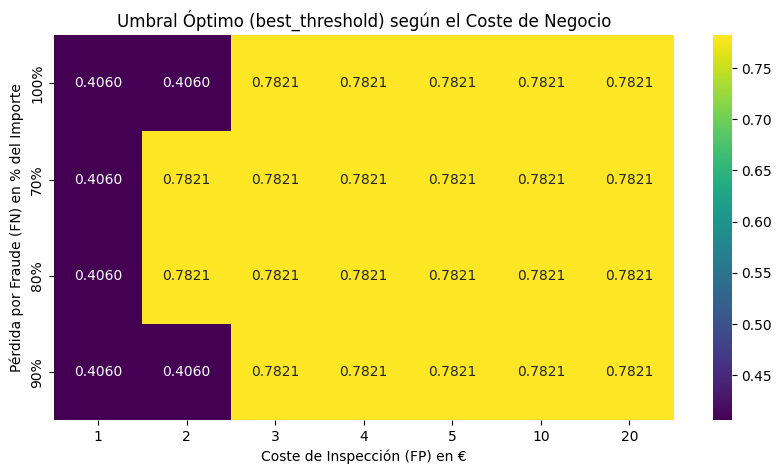

In [51]:
import os
if not os.path.exists('../results'):
    os.makedirs('../results')

# Pivotar la tabla para el heatmap de umbrales
threshold_pivot = sensitivity_df.pivot(
    index='fraud_loss_pct', 
    columns='inspect_cost_eur', 
    values='best_threshold'
)

plt.figure(figsize=(10, 5))
sns.heatmap(threshold_pivot, annot=True, fmt=".4f", cmap="viridis")
plt.title("Umbral Óptimo (best_threshold) según el Coste de Negocio")
plt.xlabel("Coste de Inspección (FP) en €")
plt.ylabel("Pérdida por Fraude (FN) en % del Importe")

output_path = '../results/heatmap_sensibilidad_umbrales.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

### 3.2. Impacto en el Coste Financiero Final

Este gráfico muestra el coste monetario mínimo (€) que se puede lograr en cada escenario, *asumiendo que elegimos el umbral óptimo* identificado arriba.

**Observación Clave:** Nótese la estabilidad horizontal de los valores. A pesar de que el coste de inspección sube (eje X), el coste total apenas varía. Esto se debe a que el modelo **ajusta su umbral** (volviéndose más conservador) para neutralizar el aumento del coste de inspección.

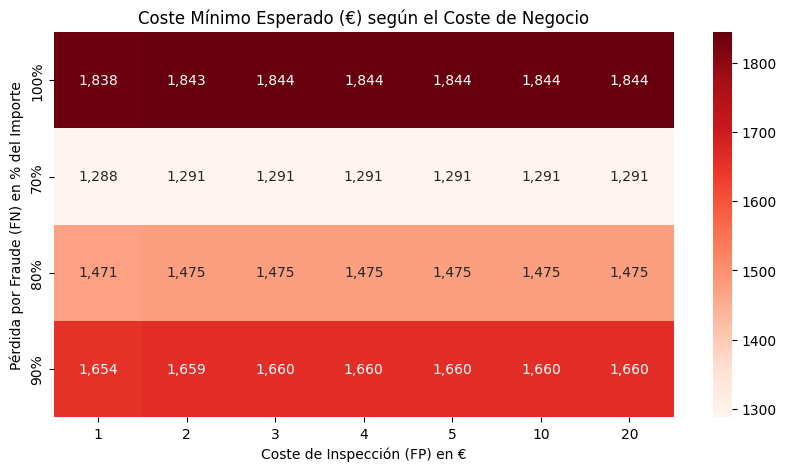

In [52]:
# Pivotar la tabla para el heatmap de costes
cost_pivot = sensitivity_df.pivot(
    index='fraud_loss_pct', 
    columns='inspect_cost_eur', 
    values='min_expected_cost'
)

plt.figure(figsize=(10, 5))
sns.heatmap(cost_pivot, annot=True, fmt=",.0f", cmap="Reds")
plt.title("Coste Mínimo Esperado (€) según el Coste de Negocio")
plt.xlabel("Coste de Inspección (FP) en €")
plt.ylabel("Pérdida por Fraude (FN) en % del Importe")

# --- GUARDAR IMAGEN ---
output_path = '../results/heatmap_sensibilidad_costes.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()


## 4. Conclusiones del Análisis de Sensibilidad

Los mapas de calor revelan la robustez y adaptabilidad del modelo **XGBoost (Factor 20)**:

1.  **Punto de Inflexión en 3€:**
    Hemos identificado un cambio de régimen claro en la estrategia de decisión:
    * **Coste de Inspección ≤ 2€:** La estrategia óptima es **Agresiva** (Umbral bajo: **0.4060**). Es rentable generar falsas alarmas para cazar más fraude.
    * **Coste de Inspección ≥ 3€:** La estrategia óptima es **Conservadora** (Umbral alto: **0.7821**). El coste de las falsas alarmas pesa más, por lo que solo se deben revisar transacciones con muy alta probabilidad de fraude.

2.  **Dominancia del Fraude Real:**
    El coste total (Gráfico 2) es altamente sensible al porcentaje de pérdida por fraude (Eje Y), variando de ~1.300€ a ~1.800€. Sin embargo, es notablemente insensible al coste de inspección (Eje X) una vez superados los 3€, gracias al ajuste dinámico del umbral.

**Recomendación Final:**
Dado el escenario base (`inspect_cost=5€`), nos situamos en la zona conservadora. La implementación final debe utilizar el modelo **XGBoost (Factor 20)** con un **umbral de decisión de 0.7821**, resultando en un coste esperado mínimo de **€1,660**.

## 5. Guardado del Modelo y Simulación de Producción

Una vez validada la estrategia, procedemos a guardar el modelo ganador y su configuración operativa para su hipotética puesta en producción.

1.  **Guardamos** el modelo entrenado (**XGBoost** con `amount_factor=20`).
2.  **Simulamos** la predicción sobre 5 transacciones aleatorias usando el umbral operativo (**0.7821**).

In [53]:
import joblib
import os

# 1. Crear carpeta de modelos si no existe
if not os.path.exists('../models'):
    os.makedirs('../models')

# 2. Definir la configuración ganadora (valores de tus gráficas)
FINAL_THRESHOLD = 0.7821 
FINAL_MODEL = xgb_best_model # El modelo que ya entrenamos al principio del notebook

# 3. Guardar el modelo
model_filename = '../models/fraud_detection_xgboost_final.pkl'
joblib.dump(FINAL_MODEL, model_filename)
print(f"Modelo guardado exitosamente en: {model_filename}")

# 4. Simulación de Inferencia (Producción)
print("\n--- SIMULACIÓN DE INFERENCIA ---")
print(f"Configuración cargada: Umbral de corte = {FINAL_THRESHOLD}")

# Seleccionar 5 muestras aleatorias del set de prueba
random_indices = np.random.choice(X_test.index, 1000, replace=False)
sample_data = X_test.loc[random_indices]
sample_amounts = amount_test.loc[random_indices]
sample_true_labels = y_test.loc[random_indices]

# Predecir probabilidad
sample_probs = FINAL_MODEL.predict_proba(sample_data)[:, 1]

print("\n{:<10} | {:<10} | {:<15} | {:<15} | {:<10}".format(
    "ID Trans.", "Importe", "Probabilidad", "Predicción", "Realidad"
))
print("-" * 75)

for i, (idx, amt, prob, true_label) in enumerate(zip(random_indices, sample_amounts, sample_probs, sample_true_labels)):
    # APLICAMOS EL UMBRAL DE NEGOCIO
    is_fraud_pred = "🚨 FRAUDE" if prob >= FINAL_THRESHOLD else "✅ LEGÍTIMA"
    is_fraud_real = "🚨 FRAUDE" if true_label == 1 else "✅ LEGÍTIMA"
    
    print("{:<10} | €{:<9.2f} | {:<15.4f} | {:<15} | {:<10}".format(
        idx, amt, prob, is_fraud_pred, is_fraud_real
    ))

Modelo guardado exitosamente en: ../models/fraud_detection_xgboost_final.pkl

--- SIMULACIÓN DE INFERENCIA ---
Configuración cargada: Umbral de corte = 0.7821

ID Trans.  | Importe    | Probabilidad    | Predicción      | Realidad  
---------------------------------------------------------------------------
263006     | €46.19     | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
46721      | €7.99      | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
44760      | €29.00     | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
81740      | €12.95     | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
198626     | €200.00    | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
277376     | €28.18     | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
10040      | €37.90     | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
164729     | €30.00     | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
189164     | €73.28     | 0.0002          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
143065     | €100.00    | 0.0000  